# [회귀]주택 가격 예측: 결측치 처리한 데이터로 모델링
---
- 예측할 값(y): SalePrice
- 평가지표: RMSE


# 시작 전 준비

In [1]:
# 구글 드라이브와 연동
from google.colab import drive
drive.mount('/content/drive')

# 파일 경로 수정
import os
print('os.getcwd():',os.getcwd())
os.chdir('/content/drive/MyDrive/Colab Notebooks/04_Machine_Learning/data/aiffel-ds-3-house-prices')
print('os.getcwd():',os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
os.getcwd(): /content
os.getcwd(): /content/drive/MyDrive/Colab Notebooks/04_Machine_Learning/data/aiffel-ds-3-house-prices


In [2]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import root_mean_squared_error


In [3]:
# 모듈 생성 - 데이터 탐색

# 훈련데이터 불러오기
def load_data():
  import pandas as pd
  train = pd.read_csv('train.csv')
  test = pd.read_csv('test.csv')
  print(f'훈련데이터 shape: {train.shape}')
  print(f'실전데이터 shape: {test.shape}')
  return train, test

# 결측치가 존재하는 컬럼 추출
def num_of_na(data):
  nas_of_data = data.isnull().sum()
  nas_of_data = nas_of_data[nas_of_data > 0].sort_values(ascending = False)  # 결측치가 1개 이상인 컬럼만 선택
  print(f"결측치가 존재하는 컬럼의 개수: {len(nas_of_data)}")
  return nas_of_data

# 결측치가 존재하는 컬럼의 비율 확인
def rate_of_na(data=None):
  nas_of_data = data.isnull().mean()
  nas_of_data = nas_of_data[nas_of_data > 0].sort_values(ascending = False)  # 결측치가 1개 이상인 컬럼만 선택
  print(f"결측치가 존재하는 컬럼의 개수: {len(nas_of_data)}")
  return nas_of_data

In [4]:
# 모듈 생성 - 데이터 전처리

# 컬럼삭제
def rm_cols(data=None, cols=None):
  data_copy = data.copy()
  print(f'컬럼 삭제 전 shape: {data_copy.shape}')
  data_copy.drop(cols, axis = 1, inplace = True)
  print(f'컬럼 삭제 후 shape: {data_copy.shape}\n')

  return data_copy


# 해당 조건을 만족하는 데이터 추출
def get_filtered_data(data=None, conds=None, cols=None):

  data_copy = data.copy()
  print(f'추출 전 데이터 shape: {data_copy.shape}')

  if cols == None:
    data_copy = data_copy.loc[conds,:]
  else:
    data_copy = data_copy.loc[conds, cols]

  print(f'추출 후 데이터 shape: {data_copy.shape}')

  return data_copy

# 데이터 확인 및 탐색

## 데이터 불러오기

In [5]:
# 훈련데이터 불러오기
train_df,test_df = load_data()

train_df.info()

훈련데이터 shape: (1168, 81)
실전데이터 shape: (292, 80)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    950 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          70 non-null     object 
 7   LotShape       1168 non-null   object 
 8   LandContour    1168 non-null   object 
 9   Utilities      1168 non-null   object 
 10  LotConfig      1168 non-null   object 
 11  LandSlope      1168 non-null   object 
 12  Neighborhood   1168 non-null   object 
 13  Condition1     1168 non-null   object 
 14  Condition2     1168 non-null   object 
 15  BldgType       1168 non-null   object 
 16  HouseStyle     1168 non-null   object 
 17  Overa

In [6]:
# 데이터 출력 - 피처가 많으므로 전체 피처가 보이게 출력
pd.set_option('display.max_columns', 100)
train_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,968,20,RL,NaN,7390,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1955,1955,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,151.0,TA,TA,CBlock,TA,TA,No,ALQ,902,Unf,0,196,1098,GasA,TA,Y,SBrkr,1098,0,0,1098,1,0,1,0,3,1,TA,6,Typ,0,NaN,Attchd,1955.0,Unf,1,260,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal,135000
1,739,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,1Story,5,5,1987,1988,Gable,CompShg,Plywood,Plywood,NaN,0.0,TA,TA,CBlock,Gd,Gd,Gd,GLQ,1200,Unf,0,0,1200,GasA,TA,Y,SBrkr,1200,0,0,1200,3,0,3,0,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,120,0,0,0,0,0,NaN,NaN,NaN,0,3,2009,WD,Alloca,179000
2,696,20,RL,54.0,13811,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,6,6,1987,1987,Gable,CompShg,HdBoard,HdBoard,BrkFace,72.0,TA,TA,CBlock,Gd,Gd,No,GLQ,980,LwQ,40,92,1112,GasA,Gd,Y,SBrkr,1137,0,0,1137,1,0,2,0,2,1,Gd,5,Typ,1,TA,Attchd,1987.0,Unf,2,551,TA,TA,Y,125,0,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal,176000


- 훈련데이터는 1168개의 관측치와 81개의 피처가 있다.
- 실전데이터는 292개의 관측치와 80개의 피처가 있다.
- 관측치의 수에 비해 피처의 개수가 많음을 알 수 있다. 피처들을 줄여 모델링을 해볼 필요가 있어보인다.
- 결측치가 존재한다.




## 중요하다고 생각하는 평가지표
---
MSE, RMSE, MAE, RMSLE, R2 중에서 생각해본다. 타겟변수인 SalePrice의 범위를 살펴본다.



In [7]:
# SalePrice
train_df['SalePrice'].describe()

,SalePrice
count,1168.000000
mean,180194.401541
std,78869.201529
min,34900.000000
25%,129500.000000
50%,163995.000000
75%,213062.500000
max,755000.000000


<Axes: ylabel='Frequency'>

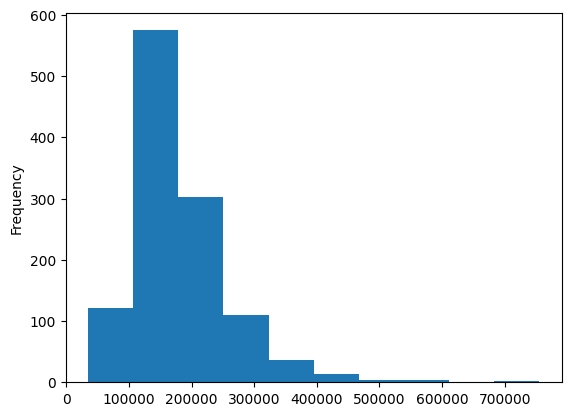

In [8]:
# SalePrice 시각화
# sns.scatterplot(x = train_df.index, y = train_df.SalePrice)
train_df.SalePrice.plot(kind = 'hist')

- SalePrice가 만 단위에서 십만 단위까지 올라가므로 MSE로 측정하기에는 값이 커질 수 있다.
- MAE 역시 MSE만큼은 아니지만 크게 나올 가능성이 있다.
- R2는 모델의 설명력을 의미하므로 과적합의 경우 설명력은 높으면서 예측력은 떨어질 수 있다고 본다.
- 가격을 예측할 때 매물을 구하는 사람들 입장에선 실제값보다 높은 가격이 나온다면 더 치명적이라고 느끼므로 실제보다 크게 나온 수치에 대해 패널티를 많이 부여하는 RMSLE가 적합하다고 본다.
- 가격을 예측할 때 매물을 내놓는 사람들의 입장에서는 실제가치보다 낮게 평가된다면 손해이므로, 예측값보다 실제값이 더 낮게 나올 경우 패널티를 부과하도록 기존의 RMSLE에서 로그변환된 예측값과 실제값을 역수로 하여 합을 구하여 만든 새로운 지표인 inverse_RMSLE를 사용해보려고 한다.
- 경진대회에서는 RMSE를 기준으로 하므로, RMSLE와 inverse_RMSLE 그리고 RMSE를 함께 보며 모델을 평가하려고 한다.

평가지표에 대한 함수를 만들어준다.

In [9]:
# RMSLE 평가지표 추출
def rmsle(y, pred):
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y - log_pred)**2
  rmsle = np.sqrt(np.mean(squared_error))
  return rmsle

# inverse_RMSLE 평가지표 추출
def inverse_rmsle(y, pred):
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y - log_pred)**(-2)
  rmsle = np.sqrt(np.mean(squared_error))
  return rmsle

# rmsle, inverse_rmsle, rmse 모두 추출
def evaluate_regr(y, pred):
  rmsle_val = rmsle(y, pred)
  inverse_rmsle_val = inverse_rmsle(y, pred)
  rmse_val = root_mean_squared_error(y, pred)

  print('RMSLE: {0:.3F}, inverse_RMSLE: {1:.3F}, RMSE: {2:.3F}'.format(rmsle_val, inverse_rmsle_val, rmse_val))

## 어떤 모델을 사용할 것인가
---
새로운 모델을 사용하기 보다 지난시간 학습했던 회귀모델을 사용하고 비교해본다. *전처리 단계에서는 결측치도 처리할 수 있는 boost계열의 모델들을 사용해 성능을 비교해본다.*
- LinearRegression
(참고용으로 statsmodels.formula.api에서 ols(ordinary linear squares)모델 사용)
- Ridge
- Lasso
- ElasticNet
- RandomForestRegressor
- XGBRegressor
- LGBMRegressor

# 결측치 처리
---
피처가 많으므로 결측치가 있는 컬럼들을 결측치가 많은 순서대로 추출한다.

In [10]:
# 결측치가 존재하는 컬럼만 추출
train_na = rate_of_na(train_df)
train_na

결측치가 존재하는 컬럼의 개수: 19


,0
PoolQC,0.994863
MiscFeature,0.958904
Alley,0.940068
Fence,0.805651
MasVnrType,0.594178
FireplaceQu,0.466610
LotFrontage,0.186644
GarageType,0.059075
GarageYrBlt,0.059075
GarageFinish,0.059075


In [11]:
# 실전데이터에서 결측치 확인 - 원래는 모르는 데이터지만, 모델링 할 때 문제가 없도록 확인
rate_of_na(test_df)

결측치가 존재하는 컬럼의 개수: 17


,0
PoolQC,0.996575
MiscFeature,0.979452
Alley,0.928082
Fence,0.815068
MasVnrType,0.609589
FireplaceQu,0.496575
LotFrontage,0.140411
BsmtFinType1,0.047945
BsmtFinType2,0.047945
BsmtExposure,0.047945


- 훈련데이터에서 결측치가 아닌 컬럼이면서 실전데이터에서 결측치를 가진 컬럼은 없는 걸로 확인된다.
- 결측치 비율을 30% 기준으로 30%를 초과하는 컬럼과 30% 이하의 컬럼으로 나누어 다루어본다.

## 결측치가 30% 이상인 컬럼
---
결측치가 30%이상인 컬럼은 확인하고 처리해준다.

In [12]:
# 결측치가 30% 이상인 컬럼
over_30p_cols = train_na[train_na > 0.3].index
over_30p_cols

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu'], dtype='object')

In [13]:
# 결측치가 30% 이상인 컬럼의 결측치비율 확인
train_df[over_30p_cols].isna().mean()

,0
PoolQC,0.994863
MiscFeature,0.958904
Alley,0.940068
Fence,0.805651
MasVnrType,0.594178
FireplaceQu,0.466610


여기서 MiscFeature는 다른 변수에서 나타낼 수 없는 정보이므로 확인해본다.

In [14]:
# MiscFeature
train_df.MiscFeature.value_counts(dropna = False)

,count
MiscFeature,
NaN,1120
Shed,43
Gar2,2
Othr,2
TenC,1


- NaN인 결측값을 제외하고 의미하는 바는 다음과 같다.

```
Shed: 창고, 헛간 등 부속 건물
Gar2: 2번째 차고(Garage)
Othr: 테니스 코트, 농장 등 기타 부속 시설
*TenC: 빌딩 유형(Tenement, Condominium 등) 또는 임대 가능 여부(Tenancy)등으로 추정(확실히는 알 수 없음)
```
- 필요한 정보라고 생각하나, 모델링에서는 크게 영향을 주지 못할 것으로 판단
- 따라서 결측치가 30%이상인 피처들은 삭제해준다.

In [15]:
# 결측치 30% 이상인 컬럼 삭제
train_df = rm_cols(train_df, over_30p_cols)
test_df = rm_cols(test_df, over_30p_cols)

컬럼 삭제 전 shape: (1168, 81)
컬럼 삭제 후 shape: (1168, 75)

컬럼 삭제 전 shape: (292, 80)
컬럼 삭제 후 shape: (292, 74)



## 결측치가 30% 이하인 컬럼

In [16]:
# 결측치가 30% 이상인 컬럼
under_30p_cols = train_na[train_na < 0.3].index
under_30p_cols

Index(['LotFrontage', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageQual', 'GarageCond', 'BsmtFinType2', 'BsmtExposure',
       'BsmtFinType1', 'BsmtCond', 'BsmtQual', 'MasVnrArea', 'Electrical'],
      dtype='object')

In [17]:
# 해당 컬럼들의 결측치 개수
num_of_na(train_df)

결측치가 존재하는 컬럼의 개수: 13


,0
LotFrontage,218
GarageType,69
GarageYrBlt,69
GarageFinish,69
GarageQual,69
GarageCond,69
BsmtExposure,24
BsmtFinType2,24
BsmtQual,23
BsmtCond,23


- 결측치가 30%이상 존재하는 컬럼들을 아래와 같은 범주로 나눠볼 수 있다.
  - LotFrontage= 부지(Property)와 연결되는 길(street) 사이에 직선거리(Linear feet)
  - Garage관련 변수: GarageYrBlt, GarageCond, GarageType, GarageFinish, GarageQual
  - Basement관련 변수: BsmtFinType2,BsmtExposure,BsmtQual,BsmtCond,BsmtFinType1
  - MasVnrArea= 평방비트 단위의 석재 베니어(건물 외벽 마감재) 면적
  - Eletrical=전기시스템


- Garage관련 변수그룹과 Basement관련 변수그룹에 결측치가 비슷하다. 두 그룹에서 각각 결측치가 있는 행이 같을 것으로 보인다.

먼저 결측치가 많은 행부터 확인한다.

### 결측치가 많은 행 확인

In [18]:
# 결측치 개수가 많은 수의 행부터 추출
na_samples = train_df.isnull().sum(axis = 1).sort_values(ascending = False)
na_samples = na_samples[na_samples != 0]
na_samples

,0
864,10
1147,10
286,10
871,10
122,10
...,...
702,1
736,1
1149,1
174,1


In [19]:
# 결측치가 10개인 행의 개수 확인
len(na_samples[na_samples == 10])

5

In [20]:
# 결측치가 10개인 행 확인

# 결측치가 10개인 인덱스
na_index = na_samples[na_samples == 10].index
train_df.loc[na_index, under_30p_cols]

,LotFrontage,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,BsmtFinType2,BsmtExposure,BsmtFinType1,BsmtCond,BsmtQual,MasVnrArea,Electrical
864,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,FuseF
1147,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,FuseP
286,70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,SBrkr
871,77.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,SBrkr
122,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,SBrkr


- 10개의 결측치를 가진 행들은 모두 Garage관련 변수와 Basement관련 변수이다.
- Garage관련 변수와 Basement관련 변수를 다룰 때 함께 처리해준다. 삭제하지 않는다.

### 결측치 컬럼 처리

- 남은 결측치 개수를 다시한 번 확인해본다.

In [21]:
# 남은 결측치 개수
num_of_na(train_df)

결측치가 존재하는 컬럼의 개수: 13


,0
LotFrontage,218
GarageType,69
GarageYrBlt,69
GarageFinish,69
GarageQual,69
GarageCond,69
BsmtExposure,24
BsmtFinType2,24
BsmtQual,23
BsmtCond,23


- 결측치가 가장 많은 LotFrontage부터 살펴보는 게 맞을 수 있으나, LotFrontage 결측치가 200개가 넘어 한가지 값으로 채우기에는 노이즈가 많이 낄 우려가 있다.
- 따라서 결측치를 채우기 위한 여러 방법을 시도하기 위해 이상치처리 이후 결측치를 채우려고 한다.


Garage관련 변수의 결측치를 확인해본다.

#### Garage관련 변수 결측치 확인

Gagrage관련 변수를 확인해보자. Garage관련변수가 결측치 개수는 모두 같다.
- 그렇다면 같은 데이터에서 동시에 결측치가 나온게 아닐까?
- 결측치가 나온 이유는 Garage가 없어서가 아닐까? GarageArea와 GarageCars변수를 통해 확인해본다.

Garage관련 변수들 중 결측치가 하나라도 포함된 데이터를 추출한다. 모두 같은 행에서 결측치가 발생했다면 행의 개수가 69개가 나올 것이다.

In [22]:
# 결측치를 가진 garage관련 데이터 추출

# garage관련 컬럼 추출
garage_cols = ['GarageYrBlt', 'GarageCond', 'GarageType', 'GarageFinish', 'GarageQual','GarageArea', 'GarageCars']

# 훈련데이터 확인
na_garage = train_df.loc[train_df[garage_cols].isna().any(axis=1), garage_cols]
print(na_garage.shape)
na_garage.head()

(69, 7)


,GarageYrBlt,GarageCond,GarageType,GarageFinish,GarageQual,GarageArea,GarageCars
1,NaN,NaN,NaN,NaN,NaN,0,0
34,NaN,NaN,NaN,NaN,NaN,0,0
35,NaN,NaN,NaN,NaN,NaN,0,0
41,NaN,NaN,NaN,NaN,NaN,0,0
69,NaN,NaN,NaN,NaN,NaN,0,0


결측치 행의 개수가 69개로, 모두 같은 데이터들에서 동시에 결측치가 발견되었음을 알 수있다. 이제 GarageArea와 GarageCars의 값이 모두 0인지 확인해준다.

In [23]:
# GarageArea와 GarageCars의 고유값 확인
print(na_garage.GarageArea.unique())
print(na_garage.GarageCars.unique())

[0]
[0]


- 0값 하나만 있음을 알수 있다. 따라서 garage관련 컬럼에서 결측치가 발생한 이유는 이들이 모두 garage가 없기 때문이다. 모두 유의미한 데이터이므로 삭제하지 않는다.
- garage관련 변수들의 타입을 확인해주고 데이터타입에 맞게 적절한 값을 대체해준다.
- 실전데이터의 garage관련 변수의 결측치도 확인해본후, 훈련데이터와 함께 처리해준다.


In [24]:
# 실전데이터에서 해당변수들의 결측치 개수 확인
test_df[garage_cols].isna().sum()

,0
GarageYrBlt,12
GarageCond,12
GarageType,12
GarageFinish,12
GarageQual,12
GarageArea,0
GarageCars,0


In [25]:
# 실전데이터에서 해당변수들의 결측치 행 확인
test_df.loc[test_df[garage_cols].isna().any(axis=1), garage_cols]

,GarageYrBlt,GarageCond,GarageType,GarageFinish,GarageQual,GarageArea,GarageCars
41,NaN,NaN,NaN,NaN,NaN,0,0
68,NaN,NaN,NaN,NaN,NaN,0,0
99,NaN,NaN,NaN,NaN,NaN,0,0
106,NaN,NaN,NaN,NaN,NaN,0,0
124,NaN,NaN,NaN,NaN,NaN,0,0
125,NaN,NaN,NaN,NaN,NaN,0,0
206,NaN,NaN,NaN,NaN,NaN,0,0
238,NaN,NaN,NaN,NaN,NaN,0,0
241,NaN,NaN,NaN,NaN,NaN,0,0
271,NaN,NaN,NaN,NaN,NaN,0,0


- 실전데이터에서도 결측치가 발생한 행이 모두 같고 GarageArea, GarageCars의 값이 0이다. 따라서 훈련데이터와 같은 방식으로 처리해준다.

In [26]:
# garage관련 변수들 데이터타입 확인
train_df[garage_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GarageYrBlt   1099 non-null   float64
 1   GarageCond    1099 non-null   object 
 2   GarageType    1099 non-null   object 
 3   GarageFinish  1099 non-null   object 
 4   GarageQual    1099 non-null   object 
 5   GarageArea    1168 non-null   int64  
 6   GarageCars    1168 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 64.0+ KB


In [27]:
# GarageYrBlt의 고유값 확인
train_df['GarageYrBlt'].unique()

array([1955.,   nan, 1987., 2007., 2003., 1976., 1950., 1990., 1953.,
       1995., 1960., 1961., 2005., 2008., 1973., 1930., 1971., 1940.,
       1941., 2004., 2006., 1974., 1958., 1999., 1998., 1972., 2002.,
       1965., 1962., 1994., 1951., 1979., 2000., 1938., 1931., 1956.,
       1948., 1949., 1977., 1988., 1952., 1978., 1927., 1935., 1966.,
       1957., 2009., 1997., 1910., 1968., 1925., 1918., 1970., 1942.,
       1996., 1959., 1964., 1963., 1926., 2001., 1980., 1989., 1983.,
       1936., 1920., 1932., 1984., 1969., 1916., 1992., 1939., 1986.,
       1924., 1923., 1975., 1981., 1985., 1954., 1993., 1928., 1946.,
       1921., 1945., 1929., 1991., 1967., 2010., 1915., 1922., 1908.,
       1982., 1937., 1933., 1947., 1914., 1934.])

GarageYrBlt는 0으로 대체해준다.

In [28]:
# GarageYrBlt 결측치 0으로 대체
train_df['GarageYrBlt'] = train_df['GarageYrBlt'].fillna(0)
test_df['GarageYrBlt'] = test_df['GarageYrBlt'].fillna(0)

- 각 변수들의 고유값을 확인하고 대체해준다.

In [29]:
# 결측치를 가진 범주형변수의 고유값 확인
train_df['GarageCond'].unique()

array(['TA', nan, 'Fa', 'Po', 'Gd'], dtype=object)

In [30]:
train_df['GarageType'].unique()

array(['Attchd', nan, 'Detchd', 'BuiltIn', 'Basment', '2Types', 'CarPort'],
      dtype=object)

In [31]:
train_df['GarageFinish'].unique()

array(['Unf', nan, 'Fin', 'RFn'], dtype=object)

In [32]:
train_df['GarageQual'].unique()

array(['TA', nan, 'Fa', 'Gd', 'Po', 'Ex'], dtype=object)

- 나머지 변수들은 'NA'라는 문자로 채워준다.

In [33]:
# 나머지 범주형변수의 결측치는 'NA'로 채워주기
cat_garage_cols = ['GarageCond', 'GarageType', 'GarageFinish', 'GarageQual','GarageArea', 'GarageCars']
train_df[cat_garage_cols] = train_df[cat_garage_cols].fillna('NA')
test_df[cat_garage_cols] = test_df[cat_garage_cols].fillna('NA')

In [34]:
# garage관련 변수 결측치 사라졌는지 확인
train_df[garage_cols].isna().sum()

,0
GarageYrBlt,0
GarageCond,0
GarageType,0
GarageFinish,0
GarageQual,0
GarageArea,0
GarageCars,0


In [35]:
test_df[garage_cols].isna().sum()

,0
GarageYrBlt,0
GarageCond,0
GarageType,0
GarageFinish,0
GarageQual,0
GarageArea,0
GarageCars,0


#### Basement관련 변수 결측치 확인

In [36]:
# Basement관련 변수 추출
bsmt_cols = ['BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtFinType1',
             'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']

# 결측치 개수 확인
num_of_na(train_df[bsmt_cols])

결측치가 존재하는 컬럼의 개수: 5


,0
BsmtFinType2,24
BsmtExposure,24
BsmtQual,23
BsmtCond,23
BsmtFinType1,23


- basement관련 변수의 결측치개수도 비슷하다. 이 경우도 같은 데이터에서 결측치가 발생한게 아닐까?
- 또한 basement가 없어서 결측치가 된게 아닐까?

결측치를 BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath와 함께 확인해준다.

In [37]:
# basement 변수에서 결측치 데이터 확인
na_bsmt = train_df.loc[train_df[bsmt_cols].isna().any(axis=1), bsmt_cols]
print(na_bsmt.shape)
na_bsmt

(25, 11)


,BsmtFinType2,BsmtExposure,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
37,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
62,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
66,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
122,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
255,NaN,No,Gd,TA,GLQ,1124,479,1603,3206,1,0
286,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
318,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
376,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
437,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
521,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0


In [38]:
# bsmt 변수들의 데이터 타입확인
train_df[bsmt_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   BsmtFinType2  1144 non-null   object
 1   BsmtExposure  1144 non-null   object
 2   BsmtQual      1145 non-null   object
 3   BsmtCond      1145 non-null   object
 4   BsmtFinType1  1145 non-null   object
 5   BsmtFinSF1    1168 non-null   int64 
 6   BsmtFinSF2    1168 non-null   int64 
 7   BsmtUnfSF     1168 non-null   int64 
 8   TotalBsmtSF   1168 non-null   int64 
 9   BsmtFullBath  1168 non-null   int64 
 10  BsmtHalfBath  1168 non-null   int64 
dtypes: int64(6), object(5)
memory usage: 100.5+ KB


- 18개의 결측치가 모두 같은 행에서 나왔고, BsmtFinType2와 BsmtExposure에서 남은 1개의 결측치는 각각 다른 행에 존재함을 알 수 있다.
- 5개 피처에서 공통으로 결측치가 발견된 행들은 나머지 피처가 모두 0으로 봐서 basement가 없는 집으로 추정된다.
- BsmtExposure에만 결측치가 있는 인덱스 1037은 BsmtFinType1, BsmtFinType2에서 Unf(Unfinished)로 되어있어 unfinished된 지하실만 존재하는 것으로 보인다(이외에도 unfBsmtFinSF1, BsmtFinSF2의 값이 0이고 BsmtUnfSF, TotalBsmtSF가 같다는 것에서 유추가능)
- BsmtFinType2에만 결측치가 존재하는 인덱스 255는 단순히 데이터 입력이 누락된 것 같은데, BsmtExposure, BsmtQual, BsmtCond, BsmtFinType1를 이용해서 결측치를 처리해본다.

먼저, 해당 변수들에서 결측치가 1개만 있는 두 데이터를 처리해준다. 다른 범주형 변수들을 통해 해당 값을 유추해 채워줄 수 있으나, test데이터에서도 결측치가 있을 경우를 대비해 각 컬럼에 해당하는 최빈값으로 대체해준다.

In [39]:
# BsmtFinType2만 결측치인 데이터
na_bsmt.loc[255]
# train_df.loc[255]

,255
BsmtFinType2,NaN
BsmtExposure,No
BsmtQual,Gd
BsmtCond,TA
BsmtFinType1,GLQ
BsmtFinSF1,1124
BsmtFinSF2,479
BsmtUnfSF,1603
TotalBsmtSF,3206
BsmtFullBath,1


In [40]:
# BsmtFinType2의 최빈값확인
train_df['BsmtFinType2'].mode()[0]

'Unf'

In [41]:
# 같은 범주안에서 찾기
# 범주를 조건으로 넣기
conds = (train_df['BsmtExposure'] == 'No') & (train_df['BsmtQual'] == 'Gd') & (train_df['BsmtCond'] == 'TA') & (train_df['BsmtFinType1'] == 'GLQ') & (train_df['BsmtFullBath'] == 1) & (train_df['BsmtHalfBath'] == 0)

train_df.loc[conds].groupby('BsmtFinType2').size()

,0
BsmtFinType2,
Unf,69


- 인덱스 255데이터를 보면 BsmtFinSF2의 값이 존재하는데, Unf라는 값을 넣어주면 말이 되지 않는다.
- BsmtExposure, BsmtQual, BsmtCond, BsmtFinType1, BsmtFullBath, BsmtHalfBath가 같은 범주안에 있는 데이터들의 BsmtFinSF2을 확인해보면 모두 'Unf'로 나온다.
- 따라서 인덱스가 255인 데이터는 삭제해준다.

In [42]:
# 인덱스 255인 데이터 삭제
print(train_df.shape)
train_df = train_df.drop(255, axis = 0)
print(train_df.shape)

(1168, 75)
(1167, 75)


In [43]:
# BsmtExposure만 결측치인 데이터
na_bsmt.loc[1037]

,1037
BsmtFinType2,Unf
BsmtExposure,NaN
BsmtQual,Gd
BsmtCond,TA
BsmtFinType1,Unf
BsmtFinSF1,0
BsmtFinSF2,0
BsmtUnfSF,936
TotalBsmtSF,936
BsmtFullBath,0


In [44]:
# BsmtExposure의 최빈값 확인
train_df['BsmtExposure'].mode()[0]

'No'

In [45]:
# BsmtExposure의 최빈값으로 대체
train_df.loc[1037, 'BsmtExposure'] = train_df['BsmtExposure'].mode()[0]
train_df.loc[1037, bsmt_cols]

,1037
BsmtFinType2,Unf
BsmtExposure,No
BsmtQual,Gd
BsmtCond,TA
BsmtFinType1,Unf
BsmtFinSF1,0
BsmtFinSF2,0
BsmtUnfSF,936
TotalBsmtSF,936
BsmtFullBath,0


- 나머지 18개의 데이터에 대해서 결측치를 채워본다.

In [46]:
train_df['BsmtFinType2'].unique()

array(['Unf', 'LwQ', 'BLQ', 'Rec', nan, 'ALQ', 'GLQ'], dtype=object)

In [47]:
train_df['BsmtExposure'].unique()

array(['No', 'Gd', 'Mn', 'Av', nan], dtype=object)

In [48]:
train_df['BsmtQual'].unique()

array(['TA', 'Gd', 'Ex', nan, 'Fa'], dtype=object)

In [49]:
train_df['BsmtCond'].unique()

array(['TA', 'Gd', nan, 'Fa', 'Po'], dtype=object)

In [50]:
train_df['BsmtFinType1'].unique()

array(['ALQ', 'GLQ', 'Unf', 'Rec', 'BLQ', nan, 'LwQ'], dtype=object)

- 모두 object타입이므로 NA라는 문자값을 넣어 대체한다.
- 실전데이터에서도 bsmt컬럼의 결측치의 개수를 확인해준다.

In [51]:
# 실전데이터에서 bsmt관련 결측치 개수 확인
num_of_na(test_df[bsmt_cols])

결측치가 존재하는 컬럼의 개수: 5


,0
BsmtFinType2,14
BsmtExposure,14
BsmtQual,14
BsmtCond,14
BsmtFinType1,14


In [52]:
test_df.loc[test_df[bsmt_cols].isna().any(axis = 1), bsmt_cols]

,BsmtFinType2,BsmtExposure,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
12,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
13,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
54,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
59,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
64,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
68,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
74,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
124,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
158,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
224,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0


- 결측치의 개수가 모두 같다. 이들 모두 같은 행에 존재하므로 basement가 없는 걸로 확인할 수 있다.

In [53]:
# NA로 대체
train_df[bsmt_cols[:5]] = train_df[bsmt_cols[:5]].fillna('NA')
test_df[bsmt_cols[:5]] = test_df[bsmt_cols[:5]].fillna('NA')

In [54]:
# bsmt관련 변수들의 결측치가 사라졌는지 확인
train_df[bsmt_cols].isna().sum()

,0
BsmtFinType2,0
BsmtExposure,0
BsmtQual,0
BsmtCond,0
BsmtFinType1,0
BsmtFinSF1,0
BsmtFinSF2,0
BsmtUnfSF,0
TotalBsmtSF,0
BsmtFullBath,0


In [55]:
test_df[bsmt_cols].isna().sum()

,0
BsmtFinType2,0
BsmtExposure,0
BsmtQual,0
BsmtCond,0
BsmtFinType1,0
BsmtFinSF1,0
BsmtFinSF2,0
BsmtUnfSF,0
TotalBsmtSF,0
BsmtFullBath,0


#### MasVnrArea, Electrical 변수의 결측치 처리
---
train, test 데이터의 결측치 개수를 다시 한 번 확인한 후 처리한다.

In [56]:
# 남은 결측치 컬럼 확인 - train
num_of_na(train_df)

결측치가 존재하는 컬럼의 개수: 3


,0
LotFrontage,218
MasVnrArea,8
Electrical,1


In [57]:
# 남은 결측치 컬럼 확인 - test
num_of_na(test_df)

결측치가 존재하는 컬럼의 개수: 1


,0
LotFrontage,41


- 훈련데이터에서 MasVnrArea와 Electrical의 결측치를 처리해준다.

먼저 MasVnrArea컬럼을 처리해준다.

In [58]:
# MasVnrType을 통해 MasVnrArea의 결측치의 정보얻기
train_tmp, test_tmp = load_data()

train_tmp.loc[train_tmp['MasVnrArea'].isna(), ['MasVnrArea','MasVnrType']]

훈련데이터 shape: (1168, 81)
실전데이터 shape: (292, 80)


,MasVnrArea,MasVnrType
40,NaN,NaN
54,NaN,NaN
136,NaN,NaN
241,NaN,NaN
421,NaN,NaN
576,NaN,NaN
588,NaN,NaN
640,NaN,NaN


- 둘 다 결측치라서 얻을 수 있는 정보가 없다.

-MasVnrArea를 시각화해서 분포를 살펴본다.

<Axes: >

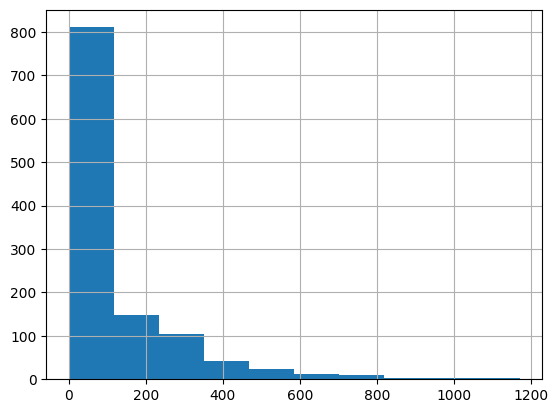

In [59]:
# MasVnrArea 시각화
train_df['MasVnrArea'].hist()

- 확실히 왼쪽으로 쏠려있다.

로그변환을 해본다.

<Axes: >

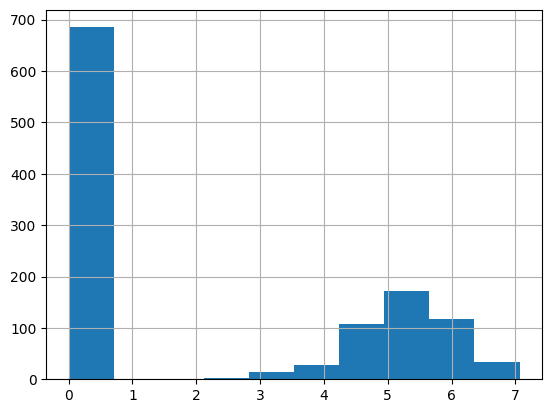

In [60]:
# MasVnrArea - 로그변환해 시각화
np.log1p(train_df['MasVnrArea']).hist()

In [61]:
# MasVnrArea가 0인 데이터의 개수
train_df['MasVnrArea'][train_df['MasVnrArea']==0].count()

683

In [62]:
# MasVnrArea가 0인 데이터의 비율
train_df['MasVnrArea'][train_df['MasVnrArea']==0].count() / len(train_df)

0.585261353898886

- 로그변환해도 변화가 없는 값이 있어, 0값의 개수와 비율을 출력한 결과 전체의 반 이상을 차지한다.
- 어디서 비슷한 숫자를 본 것 같다. 원래 데이터의 MasVnrType변수의 결측치개수와 비율을 출력해본다.

In [63]:
# MasVnrType의 결측치
display(train_tmp['MasVnrType'].isna().sum())
display(train_tmp['MasVnrType'].isna().mean())

694

0.5941780821917808

 MasVnrArea의 0값데이터 683개와 결측치 데이터가 MasVnrType의 결측치 데이터 694개에 포함되는지 확인해본다.

In [64]:
# MasVnrArea의 0값 또는 MasVnrType가 결측치인 데이터 출력
train_tmp.loc[(train_tmp['MasVnrArea'].isna()) | (train_tmp['MasVnrArea']==0), 'MasVnrType'].value_counts(dropna = False)

,count
MasVnrType,
NaN,690
Stone,1


In [65]:
# MasVnrType가 Stone인 데이터
train_tmp.loc[((train_tmp['MasVnrArea'].isna()) | (train_tmp['MasVnrArea']==0)) & (train_tmp['MasVnrType'] == 'Stone')]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
204,1242,20,RL,83.0,9849,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,6,2007,2007,Hip,CompShg,VinylSd,VinylSd,Stone,0.0,Gd,TA,PConc,Gd,TA,Av,Unf,0,Unf,0,1689,1689,GasA,Ex,Y,SBrkr,1689,0,0,1689,0,0,2,0,3,1,Gd,7,Typ,0,NaN,Attchd,2007.0,RFn,3,954,TA,TA,Y,0,56,0,0,0,0,NaN,NaN,NaN,0,6,2007,New,Partial,248328


- 하나의 데이터를 제외하고 MasVnrType가 결측치인 데이터에 포함되는 것을 알 수 있다.
- MasVnrType가 Stone이면서 MasVnrArea가 0인 데이터(인덱스 204)는 의미가 없다고 판단해 삭제해준다.
- MasVnrArea가 결측치인 데이터들은 MasVnrType도 모두 결측치이다. 이 말은 석재베니어처리가 되지 않았다고 여겨질 수 있으므로 MasVnrArea의 값을 0으로 대체해준다.

In [66]:
# 인덱스 204 데이터 삭제
print(train_df.shape)
train_df = train_df.drop(204, axis = 0)
print(train_df.shape)

(1167, 75)
(1166, 75)


In [67]:
# MasVnrArea의 결측치를 0으로 대체
train_df['MasVnrArea'] = train_df['MasVnrArea'].fillna(0)
train_df['MasVnrArea'].isna().sum()

0

**Electrical**변수의 결측치를 확인해본다.

In [68]:
train_df['Electrical'].isna().sum()

1

In [69]:
train_df[train_df['Electrical'].isna()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
858,1380,80,RL,73.0,9735,Pave,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,384,384,GasA,Gd,Y,NaN,754,640,0,1394,0,0,2,1,3,1,Gd,7,Typ,0,BuiltIn,2007.0,Fin,2,400,TA,TA,Y,100,0,0,0,0,0,0,5,2008,WD,Normal,167500


In [70]:
# Electrical의 분포확인
train_df['Electrical'].value_counts()

,count
Electrical,
SBrkr,1064
FuseA,76
FuseF,21
FuseP,3
Mix,1


- SBrkr이 1066개로 대부분을 차지하므로 해당값으로 결측값을 채워준다.

In [71]:
# SBrkr로 결측값 채우기
train_df['Electrical'] = train_df['Electrical'].fillna(train_df['Electrical'].mode()[0])
train_df['Electrical'].isna().sum()

0

# Id변수 삭제
---
관측치를 식별하는 Id변수는 주택 가격에 영향을 주는 변수가 아니므로 삭제한다.

In [72]:
# id 컬럼 삭제
train_df = rm_cols(train_df, ['Id'])

# train_df 인덱스 초기화
train_df = train_df.reset_index(drop =True)

컬럼 삭제 전 shape: (1166, 75)
컬럼 삭제 후 shape: (1166, 74)



# SalePrice 데이터변환
---
분포가 왼쪽으로 쏠려있는 SalePrice를 로그변환해준다.

<Axes: >

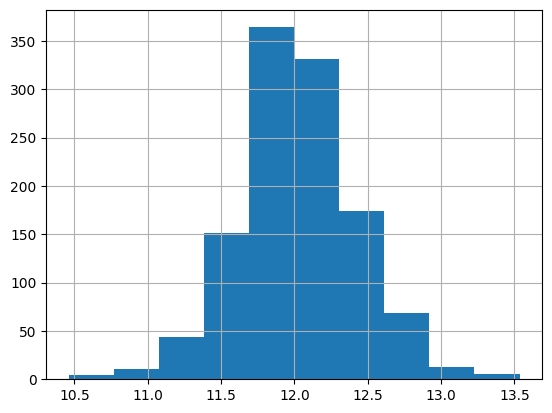

In [73]:
# SalePrices를 로그변환
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])
train_df['SalePrice'].hist()

# 범주형 변수 원핫인코딩

In [74]:
# 원핫인코딩
from sklearn.preprocessing import OneHotEncoder

# 사용할 컬럼 추출
cat_cols = train_df.select_dtypes(include = 'object').columns
print(cat_cols)

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [75]:
# 원핫인코딩으로 변환
ohe = OneHotEncoder(sparse_output = False, handle_unknown='infrequent_if_exist')
df_cat = pd.DataFrame(ohe.fit_transform(train_df[cat_cols]), columns = ohe.get_feature_names_out())
print(df_cat.shape)
df_cat.head(3)

(1166, 236)


,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,...,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,GarageFinish_Fin,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_NA,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [76]:
# 기존 데이터셋과 원핫인코딩 데이터셋 합치기
train_df = pd.concat([train_df, df_cat], axis = 1)

# 원래 컬럼 삭제
train_df = train_df.drop(cat_cols, axis = 1)
train_df

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,...,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,GarageFinish_Fin,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_NA,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,20,NaN,7390,5,7,1955,1955,151.0,902,0,196,1098,1098,0,0,1098,1,0,1,0,3,1,6,0,1955.0,1,260,0,0,0,0,0,0,0,7,2008,11.813037,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,90,60.0,10800,5,5,1987,1988,0.0,1200,0,0,1200,1200,0,0,1200,3,0,3,0,3,1,5,0,0.0,0,0,120,0,0,0,0,0,0,3,2009,12.095147,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,20,54.0,13811,6,6,1987,1987,72.0,980,40,92,1112,1137,0,0,1137,1,0,2,0,2,1,5,1,1987.0,2,551,125,0,0,0,0,0,0,7,2006,12.078245,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,20,93.0,12030,8,5,2007,2007,254.0,0,0,1694,1694,1694,0,0,1694,0,0,2,0,3,1,7,0,2007.0,3,818,168,228,0,0,0,0,0,12,2007,12.669810,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,50,60.0,8064,5,7,1949,2006,0.0,0,0,672,672,672,252,0,924,0,0,1,0,3,1,6,1,2003.0,2,576,0,0,0,0,0,0,2000,7,2007,11.719134,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161,50,63.0,11426,7,5,2003,2003,0.0,0,0,1362,1362,1362,720,0,2082,0,0,2,1,3,1,6,0,2003.0,2,484,280,238,0,0,0,0,0,6,2008,12.206078,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,

# MinMaxScaler 적용

In [77]:
from sklearn.preprocessing import StandardScaler

mm =StandardScaler()
target = train_df['SalePrice']
train_df = train_df.drop('SalePrice', axis = 1)
train_df = pd.DataFrame(data=mm.fit_transform(train_df), columns=train_df.columns)

display(train_df.head())

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,...,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,GarageFinish_Fin,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_NA,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.876070,NaN,-0.335264,-0.803730,1.244992,-0.532024,-1.449689,0.277999,0.994209,-0.279116,-0.858664,0.092530,-0.160330,-0.787864,-0.113664,-0.771492,1.109041,-0.241432,-1.017993,-0.768609,0.163184,-0.210759,-0.311089,-0.957056,0.200492,-1.018703,-0.982320,-0.736045,-0.697115,-0.360825,-0.110233,-0.278001,-0.071054,-0.092957,0.256505,0.128306,-0.071919,-0.216052,-0.106183,0.519762,-0.423047,-0.065625,0.065625,1.399782,-0.170664,-0.083117,-1.296325,-0.207205,-0.186025,-0.148022,...,-0.170664,-0.824691,1.012080,-0.09759,-0.058671,-0.144968,-0.148022,-0.101974,-0.029298,0.265908,-0.050789,0.833527,-0.117954,-0.256541,-0.088197,-0.600467,-0.250796,-0.560842,-0.250796,-0.624299,1.172495,-0.029298,-0.193304,-0.11024,-0.250796,-0.050789,0.352700,-0.15102,-0.077715,-0.250796,-0.077715,0.321126,-0.260318,-0.141854,0.301229,-0.167984,-0.058671,-0.029298,-0.077715,-0.058671,-0.058671,-0.297829,-0.041451,0.382765,-0.267752,-0.058671,-0.097590,-0.121637,0.465960,-0.302920
1,0.779518,-0.404954,0.052738,-0.803730,-0.528570,0.522584,0.145699,-0.581414,1.639299,-0.279116,-1.305231,0.327283,0.099684,-0.787864,-0.113664,-0.581158,4.969164,-0.241432,2.606373,-0.768609,0.163184,-0.210759,-0.920718,-0.957056,-3.981941,-2.360859,-2.203632,0.233203,-0.697115,-0.360825,-0.110233,-0.278001,-0.071054,-0.092957,-1.216819,0.883888,-0.071919,-0.216052,-0.106183,0.519762,-0.423047,-0.065625,0.065625,-0.714397,-0.170664,-0.083117,0.771411,-0.207205,-0.186025,-0.148022,...,-0.170664,-0.824691,1.012080,-0.09759,-0.058671,-0.144968,-0.148022,-0.101974,-0.029298,0.265908,-0.050789,-1.199721,-0.117954,-0.256541,-0.088197,-0.600467,3.987299,-0.560842,3.987299,-0.624299,-0.852882,-0.029298,-0.193304,-0.11024,3.987299,-0.050789,-2.835271,-0.15102,-0.077715,3.987299,-0.077715,-3.114040,-0.260318,-0.141854,0.301229,-0.167984,-0.058671,-0.029298,-0.077715,-0.058671,-0.058671,-0.297829,-0.041451,0.382765,-0.267752,-0.058671,10.246951,-0.121637,-2.146106,-0.302920
2,-0.876070,-0.647210,0.395341,-0.074998,0.358211,0.522584,0.097354,-0.171628,1.163058,-0.014550,-1.095618,0.124751,-0.060913,-0.787864,-0.113664,-0.698717,1.109041,-0.241432,0.794190,-0.768609,-1.048745,-0.210759,-0.920718,0.571612,0.268951,0.323453,0.384611,0.273588,-0.697115,-0.360825,-0.110233,-0.278001,-0.071054,-0.092957,0.256505,-1.382857,-0.071919,-0.216052,-0.106183,0.519762,-0.423047,-0.065625,0.065625,1.399782,-0.170664,-0.083117,-1.296325,-0.207205,-0.186025,-0.148022,...,-0.170664,1.212575,-0.988064,-0.09759,-0.058671,-0.144968,-0.148022,-0.101974,-0.029298,0.265908,-0.050789,0.833527,-0.117954,-0.256541,-0.088197,-0.600467,-0.250796,-0.560842,-0.

# 데이터 나누기

In [78]:
# 훈련데이터와 검증데이터로 나누기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df,
                                                    target,
                                                    test_size = 0.2,
                                                    random_state = 42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(932, 272) (234, 272) (932,) (234,)


# 부스트 계열 모델링

In [79]:
# XGBoost
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

xgb = XGBRegressor(random_state = 42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

evaluate_regr(np.expm1(y_test), np.expm1(xgb_pred))

# RMSLE: 0.139, inverse_RMSLE: 388.897, RMSE: 27738.489

RMSLE: 0.139, inverse_RMSLE: 153.601, RMSE: 27595.700


In [80]:
# RandomForest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state = 42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

evaluate_regr(np.expm1(y_test), np.expm1(rf_pred))
# RMSLE: 0.135, inverse_RMSLE: 322.228, RMSE: 26228.375

RMSLE: 0.141, inverse_RMSLE: 177.979, RMSE: 27800.513


In [81]:
# lgbm
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(random_state = 42)

lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)

evaluate_regr(np.expm1(y_test), np.expm1(lgbm_pred))
# RMSLE: 0.127, inverse_RMSLE: 158.558, RMSE: 24172.144

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3127
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 163
[LightGBM] [Info] Start training from score 12.017681
RMSLE: 0.136, inverse_RMSLE: 286.415, RMSE: 27265.641


In [82]:
# xgboost와 lgbm모델의 예측치를 1:1로 혼합해서 새로운 예측치 만들어 적용
mix_pred = np.expm1(lgbm_pred)*0.5 + np.expm1(xgb_pred)*0.5
evaluate_regr(np.expm1(y_test), mix_pred)

RMSLE: 0.132, inverse_RMSLE: 145.686, RMSE: 26159.746


# 테스트데이터에 적용

In [83]:
# test데이터에서 id 추출
test_id = test_df['Id']

# test데이터에 맞게 변환
def get_preprocessed_data(data=None):

  print(f'적용 전 데이터 shape: {data.shape}')
  data = data.drop('Id', axis = 1)

  cat_data = pd.DataFrame(ohe.transform(data[cat_cols]), columns = ohe.get_feature_names_out())
  print(cat_data.shape)

  # 기존 데이터셋과 원핫인코딩 데이터셋 합치기
  data = pd.concat([data, cat_data], axis = 1)

  # 원래 컬럼 삭제
  data = data.drop(cat_cols, axis = 1)
  print(f'적용 후 데이터 shape: {data.shape}')

  data = pd.DataFrame(data=mm.transform(data), columns=data.columns)
  return data

def get_predicted_data(data=None):

  pp_data = get_preprocessed_data(data)

  xgb_test_pred = xgb.predict(pp_data)
  lgbm_test_pred = lgbm.predict(pp_data)


  mix_test_pred = np.expm1(xgb_test_pred)*0.5 + np.expm1(lgbm_test_pred)*0.5

  return mix_test_pred

In [84]:
# 테스트 데이터에 적용
test_pred = get_predicted_data(test_df)
np.shape(test_pred)  # 예측값의 개수 확인

적용 전 데이터 shape: (292, 74)
(292, 236)
적용 후 데이터 shape: (292, 272)


(292,)

# 제출파일 변환

In [85]:
# 파일제출
sub_nan = pd.DataFrame({'Id':test_id, 'SalePrice': test_pred})
sub_nan

,Id,SalePrice
0,86,280595.331701
1,227,265872.543682
2,492,166035.841043
3,64,149618.542641
4,576,112041.092606
...,...,...
287,1271,206785.394118
288,903,182481.145420
289,1019,179199.513534
290,312,123853.679433


In [86]:
# sub_nan.to_csv('sub_nan.csv', index = False)